# Spatial reconstruction amplitudes; Ext vs CCE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits
import CCE
from qnmfits.spatial_mapping_functions import *
from matplotlib.lines import Line2D

plt.style.use("stylesheet.mplstyle")
fig_width = 246.0 * (1.0 / 72.27)
fig_height = fig_width / 1.618

In [2]:
id = "0001"

sim_CCE = CCE.SXS_CCE(id, lev="Lev5", radius="R2")
sim_ext = qnmfits.SXS(id, zero_time=(2, 2))

t0 = 17

l_max = 8
n_max = 7

t0_array = np.linspace(-30, 100, 100)
mapping = [(2, 2, 0, 1)]

map = mapping[0]
lp, mp, npp, pp = map

QNMs = [(lam, mp, n, p) for lam in np.arange(mp, l_max + 1) for n in np.arange(0, n_max + 1) for p in (-1, +1)]

spherical_modes = [(lam, mp) for lam in np.arange(2, l_max + 1)]

Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0001v6/Lev5/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0001v6/Lev5/rhOverM_Asymptotic_GeometricUnits_CoM.h5


  0%|          | 0/142641207 [00:00<?, ?it/s]

In [3]:
amplitude_array_CCE = np.zeros((len(t0_array), len(spherical_modes)))
amplitude_array_ext = np.zeros((len(t0_array), len(spherical_modes)))

for j, step in enumerate(t0_array):

    best_fit_CCE = mapping_multimode_ringdown_fit(
        sim_CCE.times,
        sim_CCE.h,
        modes=QNMs.copy(),
        Mf=sim_CCE.Mf,
        chif=sim_CCE.chif_mag,
        t0=step,
        mapping_modes=mapping,
        spherical_modes=spherical_modes,
    )

    mask = np.array([mode == map for mode in best_fit_CCE["modes"]])
    amplitude_array_CCE[j, :] = np.abs(best_fit_CCE["C"][mask])

    best_fit_ext = mapping_multimode_ringdown_fit(
        sim_ext.times,
        sim_ext.h,
        modes=QNMs.copy(),
        Mf=sim_ext.Mf,
        chif=sim_ext.chif_mag,
        t0=step,
        mapping_modes=mapping,
        spherical_modes=spherical_modes,
    )

    amplitude_array_ext[j, :] = np.abs(best_fit_ext["C"][mask])

/tmp/ipykernel_45407/1277335371.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("viridis", 7)
/tmp/ipykernel_45407/1277335371.py:14: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  ax.plot(t0_array, C_tau_CCE, alpha=1, color=colors(sph[0] - 2), label=sph)


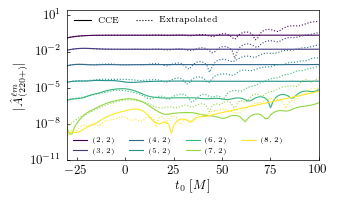

In [4]:
fig, ax = plt.subplots(figsize=(fig_width * 1.015, fig_height), ncols=1, nrows=1, sharex=True)
colors = plt.cm.get_cmap("viridis", 7)

decay_time = qnmfits.qnm.omega_list([mapping[0]], sim_CCE.chif_mag, sim_CCE.Mf)[0].imag

for i, sph in enumerate(spherical_modes):

    C_CCE = amplitude_array_CCE[:, i]
    C_ext = amplitude_array_ext[:, i]
    C_tau_CCE = C_CCE * np.exp(decay_time * (t0 - t0_array))
    C_tau_ext = C_ext * np.exp(decay_time * (t0 - t0_array))

    if sph[1] == 2:
        ax.plot(t0_array, C_tau_CCE, alpha=1, color=colors(sph[0] - 2), label=sph)
        ax.plot(t0_array, C_tau_ext, alpha=1, linestyle=":", color=colors(sph[0] - 2))

ax.set_ylabel(r"$|\hat{A}^{\ell m}_{(220+)}|$")
ax.set_xlabel(r"$t_0 \ [M]$")
ax.set_yscale("log")
ax.set_xlim(np.min(t0_array), np.max(t0_array))
ax.set_ylim(1e-11, 3e1)

solid_line1 = Line2D([0], [0], color="black", linestyle="-")
dashed_line1 = Line2D([0], [0], color="black", linestyle=":")
color_legend1 = ax.legend(ncol=4, frameon=False, loc="lower left", fontsize=5)
line_legend1 = ax.legend(
    [solid_line1, dashed_line1],
    ["CCE", "Extrapolated"],
    frameon=False,
    loc="upper left",
    ncol=2,
    fontsize=6,
)
ax.add_artist(color_legend1)

plt.show()
fig.savefig("figs/sm_mismatch_loudest_ext_vs_CCE.pdf", bbox_inches="tight")